In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import numba
from numba import jit

In [2]:
files = ["eurusd2018.csv","eurusd2017.csv","eurusd2016.csv"]
table = pd.read_csv(files[0], ";", index_col=False,
        names=["timestamp", "open", "high", "low", "close"])
table = table.append(pd.read_csv(files[1], ";", index_col=False,
        names=["timestamp", "open", "high", "low", "close"]), sort=False, ignore_index=True)
table = table.append(pd.read_csv(files[2], ";", index_col=False,
        names=["timestamp", "open", "high", "low", "close"]), sort=False, ignore_index=True)
table = table.sort_values(by="timestamp").reset_index(drop=True)
table['timestamp'] = table['timestamp'].transform(lambda x:
        time.mktime(datetime.datetime.strptime(x, "%Y%m%d %H%M%S").timetuple())).astype(np.int64)
table['year'] = table['timestamp'].transform(lambda x:
        datetime.datetime.utcfromtimestamp(x).year).astype('int')
table['day'] = table['timestamp'].transform(lambda x: 
        datetime.datetime.utcfromtimestamp(x).timetuple().tm_yday).astype('int')
table['hour'] = table['timestamp'].transform(lambda x:
        datetime.datetime.utcfromtimestamp(x).hour).astype('int')

In [3]:
days = table.drop_duplicates(['day','year']).reset_index(drop=True)
hours = table.drop_duplicates(['hour','day','year']).reset_index(drop=True)
minutes = table

#days = table
timeframe = pd.DataFrame.from_dict(hours).drop(columns=["year","day","hour"])
print(timeframe)

        timestamp     open     high      low    close
0      1451836800  1.08701  1.08713  1.08701  1.08713
1      1451840400  1.08662  1.08665  1.08633  1.08643
2      1451844000  1.08517  1.08564  1.08517  1.08564
3      1451847600  1.08453  1.08464  1.08451  1.08464
4      1451851200  1.08599  1.08645  1.08599  1.08642
5      1451854800  1.08714  1.08726  1.08711  1.08726
6      1451858400  1.08712  1.08725  1.08711  1.08725
7      1451862000  1.08794  1.08794  1.08783  1.08783
8      1451865600  1.08972  1.08972  1.08950  1.08952
9      1451869200  1.08887  1.08943  1.08887  1.08942
10     1451872800  1.09126  1.09167  1.09106  1.09160
11     1451876400  1.09240  1.09263  1.09239  1.09259
12     1451880000  1.09290  1.09327  1.09280  1.09324
13     1451883600  1.09056  1.09067  1.09045  1.09050
14     1451887200  1.09170  1.09199  1.09168  1.09184
15     1451890800  1.09001  1.09030  1.08984  1.09001
16     1451894400  1.08545  1.08567  1.08519  1.08528
17     1451898000  1.08380  

In [4]:
@jit(nopython=True)
def EMA(data, N, start):
    a = 2/(N+1)
    ret = 0
    den = 0
    for i in range(N+1):
        if (data[start-i]==np.nan):
            return np.nan
        ret = ret + data[start-i]*((1-a)**i)
        den = den + (1-a)**i
    return ret/den

@jit(nopython=True)
def MACD(data, start):
    if (start<26):
        return np.nan
    else:
        return EMA(data, 12, start) - EMA(data, 26, start)

In [5]:
data = timeframe['close'].values
colMACD = np.empty(data.size)
colSIGNAL = np.empty(data.size)
for i in range(data.size):
    colMACD[i]=MACD(data,i)
for i in range(data.size):
    colSIGNAL[i]=EMA(colMACD, 9, i)
timeframe["MACD"] = pd.DataFrame({"col":colMACD})
timeframe["SIGNAL"] = pd.DataFrame({"col":colSIGNAL})

In [17]:
balance = 1000
spread = 0.0002 #2 pips
mgs = None
prevMgs = mgs
prevPrices = None
status = None
tradeAmount = 10000 #microlot
buys = []
sells = []
balanceTab = []

for i in range(timeframe.shape[0]):
    balanceTab.append(balance)
    if not np.isnan(timeframe["MACD"][i]) and not np.isnan(timeframe["SIGNAL"][i]):
        if timeframe["MACD"][i]>timeframe["SIGNAL"][i]:
            mgs=True
        else:
            mgs=False
        #buy
        if prevMgs==False and mgs==True:
            if status=="sold":
                balance += float(prevPrices["close"]-timeframe["close"][i]-spread)*tradeAmount;
            status = "bought"
            prevPrices = timeframe[timeframe.index==i]
            buys.append(i)
            
        #sell
        if  prevMgs==True and mgs==False:
            if status=="bought":
                balance += float(timeframe["close"][i]-prevPrices["close"]-spread)*tradeAmount;
            status = "sold"
            prevPrices = timeframe[timeframe.index==i]
            sells.append(i)
        print (i,"xd",balance,"xd",status)
        prevMgs = mgs

35 xd 1000 xd None
36 xd 1000 xd sold
37 xd 1000 xd sold
38 xd 1000 xd sold
39 xd 1000 xd sold
40 xd 1000 xd sold
41 xd 1000 xd sold
42 xd 1000 xd sold
43 xd 1000 xd sold
44 xd 1000 xd sold
45 xd 1000 xd sold
46 xd 1000 xd sold
47 xd 1027.7999999999997 xd bought
48 xd 1027.7999999999997 xd bought
49 xd 1027.7999999999997 xd bought
50 xd 1027.7999999999997 xd bought
51 xd 1027.7999999999997 xd bought
52 xd 1027.7999999999997 xd bought
53 xd 1027.7999999999997 xd bought
54 xd 1027.7999999999997 xd bought
55 xd 1027.7999999999997 xd bought
56 xd 1027.7999999999997 xd bought
57 xd 1027.7999999999997 xd bought
58 xd 1027.7999999999997 xd bought
59 xd 1027.7999999999997 xd bought
60 xd 1027.7999999999997 xd bought
61 xd 1027.7999999999997 xd bought
62 xd 1027.7999999999997 xd bought
63 xd 1027.7999999999997 xd bought
64 xd 1027.7999999999997 xd bought
65 xd 1027.7999999999997 xd bought
66 xd 1027.7999999999997 xd bought
67 xd 1027.7999999999997 xd bought
68 xd 1027.7999999999997 xd bought
69

402 xd 776.5999999999918 xd sold
403 xd 776.5999999999918 xd sold
404 xd 776.5999999999918 xd sold
405 xd 783.7999999999921 xd bought
406 xd 783.7999999999921 xd bought
407 xd 783.7999999999921 xd bought
408 xd 783.7999999999921 xd bought
409 xd 783.7999999999921 xd bought
410 xd 783.7999999999921 xd bought
411 xd 783.7999999999921 xd bought
412 xd 783.7999999999921 xd bought
413 xd 783.7999999999921 xd bought
414 xd 783.7999999999921 xd bought
415 xd 783.7999999999921 xd bought
416 xd 783.7999999999921 xd bought
417 xd 783.7999999999921 xd bought
418 xd 783.7999999999921 xd bought
419 xd 783.7999999999921 xd bought
420 xd 783.7999999999921 xd bought
421 xd 783.7999999999921 xd bought
422 xd 783.7999999999921 xd bought
423 xd 783.7999999999921 xd bought
424 xd 783.7999999999921 xd bought
425 xd 783.7999999999921 xd bought
426 xd 816.6999999999942 xd sold
427 xd 816.6999999999942 xd sold
428 xd 816.6999999999942 xd sold
429 xd 816.6999999999942 xd sold
430 xd 784.4999999999962 xd bought

702 xd 842.5999999999852 xd sold
703 xd 842.5999999999852 xd sold
704 xd 842.5999999999852 xd sold
705 xd 842.5999999999852 xd sold
706 xd 842.5999999999852 xd sold
707 xd 842.5999999999852 xd sold
708 xd 842.5999999999852 xd sold
709 xd 842.5999999999852 xd sold
710 xd 842.5999999999852 xd sold
711 xd 842.5999999999852 xd sold
712 xd 842.5999999999852 xd sold
713 xd 842.5999999999852 xd sold
714 xd 842.5999999999852 xd sold
715 xd 842.5999999999852 xd sold
716 xd 842.5999999999852 xd sold
717 xd 842.5999999999852 xd sold
718 xd 842.5999999999852 xd sold
719 xd 922.5999999999851 xd bought
720 xd 922.5999999999851 xd bought
721 xd 922.5999999999851 xd bought
722 xd 884.3999999999834 xd sold
723 xd 866.0999999999832 xd bought
724 xd 866.0999999999832 xd bought
725 xd 866.0999999999832 xd bought
726 xd 866.0999999999832 xd bought
727 xd 866.0999999999832 xd bought
728 xd 866.0999999999832 xd bought
729 xd 866.0999999999832 xd bought
730 xd 866.0999999999832 xd bought
731 xd 866.0999999999

1053 xd 321.29999999999205 xd bought
1054 xd 321.29999999999205 xd bought
1055 xd 321.29999999999205 xd bought
1056 xd 321.29999999999205 xd bought
1057 xd 321.29999999999205 xd bought
1058 xd 321.29999999999205 xd bought
1059 xd 399.69999999999254 xd sold
1060 xd 399.69999999999254 xd sold
1061 xd 399.69999999999254 xd sold
1062 xd 399.69999999999254 xd sold
1063 xd 399.69999999999254 xd sold
1064 xd 399.69999999999254 xd sold
1065 xd 399.69999999999254 xd sold
1066 xd 399.69999999999254 xd sold
1067 xd 399.69999999999254 xd sold
1068 xd 399.69999999999254 xd sold
1069 xd 399.69999999999254 xd sold
1070 xd 399.69999999999254 xd sold
1071 xd 399.69999999999254 xd sold
1072 xd 354.29999999999245 xd bought
1073 xd 354.29999999999245 xd bought
1074 xd 354.29999999999245 xd bought
1075 xd 354.29999999999245 xd bought
1076 xd 354.29999999999245 xd bought
1077 xd 354.29999999999245 xd bought
1078 xd 354.29999999999245 xd bought
1079 xd 354.29999999999245 xd bought
1080 xd 345.29999999999325 

1402 xd 130.3000000000003 xd bought
1403 xd 98.30000000000138 xd sold
1404 xd 98.30000000000138 xd sold
1405 xd 74.70000000000198 xd bought
1406 xd 74.70000000000198 xd bought
1407 xd 49.900000000001384 xd sold
1408 xd 49.900000000001384 xd sold
1409 xd 31.300000000001436 xd bought
1410 xd 17.500000000004064 xd sold
1411 xd 7.600000000005599 xd bought
1412 xd 7.600000000005599 xd bought
1413 xd 7.600000000005599 xd bought
1414 xd 7.600000000005599 xd bought
1415 xd 7.600000000005599 xd bought
1416 xd 7.600000000005599 xd bought
1417 xd 7.600000000005599 xd bought
1418 xd 7.600000000005599 xd bought
1419 xd 7.600000000005599 xd bought
1420 xd 7.600000000005599 xd bought
1421 xd -0.5999999999950507 xd sold
1422 xd -0.5999999999950507 xd sold
1423 xd -0.5999999999950507 xd sold
1424 xd -0.5999999999950507 xd sold
1425 xd -0.5999999999950507 xd sold
1426 xd -0.5999999999950507 xd sold
1427 xd -0.5999999999950507 xd sold
1428 xd -0.5999999999950507 xd sold
1429 xd -0.5999999999950507 xd sol

1766 xd -314.00000000001364 xd bought
1767 xd -314.00000000001364 xd bought
1768 xd -314.00000000001364 xd bought
1769 xd -314.00000000001364 xd bought
1770 xd -314.00000000001364 xd bought
1771 xd -314.00000000001364 xd bought
1772 xd -314.00000000001364 xd bought
1773 xd -314.00000000001364 xd bought
1774 xd -314.00000000001364 xd bought
1775 xd -314.00000000001364 xd bought
1776 xd -314.00000000001364 xd bought
1777 xd -314.00000000001364 xd bought
1778 xd -314.00000000001364 xd bought
1779 xd -314.00000000001364 xd bought
1780 xd -335.6000000000155 xd sold
1781 xd -335.6000000000155 xd sold
1782 xd -335.6000000000155 xd sold
1783 xd -335.6000000000155 xd sold
1784 xd -335.6000000000155 xd sold
1785 xd -335.6000000000155 xd sold
1786 xd -335.6000000000155 xd sold
1787 xd -335.6000000000155 xd sold
1788 xd -348.6000000000165 xd bought
1789 xd -348.6000000000165 xd bought
1790 xd -348.6000000000165 xd bought
1791 xd -348.6000000000165 xd bought
1792 xd -348.6000000000165 xd bought
179

2102 xd -635.5000000000246 xd bought
2103 xd -635.5000000000246 xd bought
2104 xd -635.5000000000246 xd bought
2105 xd -635.5000000000246 xd bought
2106 xd -635.5000000000246 xd bought
2107 xd -635.5000000000246 xd bought
2108 xd -635.5000000000246 xd bought
2109 xd -635.5000000000246 xd bought
2110 xd -635.5000000000246 xd bought
2111 xd -635.5000000000246 xd bought
2112 xd -635.5000000000246 xd bought
2113 xd -635.5000000000246 xd bought
2114 xd -635.5000000000246 xd bought
2115 xd -635.5000000000246 xd bought
2116 xd -645.6000000000265 xd sold
2117 xd -645.6000000000265 xd sold
2118 xd -645.6000000000265 xd sold
2119 xd -645.6000000000265 xd sold
2120 xd -645.6000000000265 xd sold
2121 xd -645.6000000000265 xd sold
2122 xd -645.6000000000265 xd sold
2123 xd -645.6000000000265 xd sold
2124 xd -645.6000000000265 xd sold
2125 xd -645.6000000000265 xd sold
2126 xd -645.6000000000265 xd sold
2127 xd -645.6000000000265 xd sold
2128 xd -645.6000000000265 xd sold
2129 xd -645.6000000000265 

2502 xd -851.4000000000256 xd sold
2503 xd -851.4000000000256 xd sold
2504 xd -851.4000000000256 xd sold
2505 xd -851.4000000000256 xd sold
2506 xd -851.4000000000256 xd sold
2507 xd -851.4000000000256 xd sold
2508 xd -851.4000000000256 xd sold
2509 xd -851.4000000000256 xd sold
2510 xd -851.4000000000256 xd sold
2511 xd -851.4000000000256 xd sold
2512 xd -851.4000000000256 xd sold
2513 xd -851.4000000000256 xd sold
2514 xd -851.4000000000256 xd sold
2515 xd -851.4000000000256 xd sold
2516 xd -851.4000000000256 xd sold
2517 xd -851.4000000000256 xd sold
2518 xd -851.4000000000256 xd sold
2519 xd -851.4000000000256 xd sold
2520 xd -851.4000000000256 xd sold
2521 xd -851.4000000000256 xd sold
2522 xd -851.4000000000256 xd sold
2523 xd -851.4000000000256 xd sold
2524 xd -851.4000000000256 xd sold
2525 xd -851.4000000000256 xd sold
2526 xd -776.7000000000271 xd bought
2527 xd -776.7000000000271 xd bought
2528 xd -776.7000000000271 xd bought
2529 xd -776.7000000000271 xd bought
2530 xd -776

2902 xd -324.10000000002566 xd sold
2903 xd -324.10000000002566 xd sold
2904 xd -324.10000000002566 xd sold
2905 xd -324.10000000002566 xd sold
2906 xd -324.10000000002566 xd sold
2907 xd -324.10000000002566 xd sold
2908 xd -312.100000000025 xd bought
2909 xd -312.100000000025 xd bought
2910 xd -312.100000000025 xd bought
2911 xd -312.100000000025 xd bought
2912 xd -312.100000000025 xd bought
2913 xd -312.100000000025 xd bought
2914 xd -312.100000000025 xd bought
2915 xd -312.100000000025 xd bought
2916 xd -312.100000000025 xd bought
2917 xd -312.100000000025 xd bought
2918 xd -312.100000000025 xd bought
2919 xd -330.20000000002386 xd sold
2920 xd -330.20000000002386 xd sold
2921 xd -330.20000000002386 xd sold
2922 xd -330.20000000002386 xd sold
2923 xd -330.20000000002386 xd sold
2924 xd -330.20000000002386 xd sold
2925 xd -330.20000000002386 xd sold
2926 xd -330.20000000002386 xd sold
2927 xd -330.20000000002386 xd sold
2928 xd -330.20000000002386 xd sold
2929 xd -330.20000000002386 

3302 xd -578.2000000000145 xd bought
3303 xd -578.2000000000145 xd bought
3304 xd -578.2000000000145 xd bought
3305 xd -578.2000000000145 xd bought
3306 xd -578.2000000000145 xd bought
3307 xd -578.2000000000145 xd bought
3308 xd -578.2000000000145 xd bought
3309 xd -578.2000000000145 xd bought
3310 xd -578.2000000000145 xd bought
3311 xd -578.2000000000145 xd bought
3312 xd -578.2000000000145 xd bought
3313 xd -578.2000000000145 xd bought
3314 xd -539.1000000000139 xd sold
3315 xd -539.1000000000139 xd sold
3316 xd -539.1000000000139 xd sold
3317 xd -539.1000000000139 xd sold
3318 xd -539.1000000000139 xd sold
3319 xd -539.1000000000139 xd sold
3320 xd -539.1000000000139 xd sold
3321 xd -539.1000000000139 xd sold
3322 xd -539.1000000000139 xd sold
3323 xd -539.1000000000139 xd sold
3324 xd -539.1000000000139 xd sold
3325 xd -539.1000000000139 xd sold
3326 xd -539.1000000000139 xd sold
3327 xd -594.6000000000158 xd bought
3328 xd -594.6000000000158 xd bought
3329 xd -594.6000000000158 

3702 xd -378.1000000000081 xd bought
3703 xd -378.1000000000081 xd bought
3704 xd -378.1000000000081 xd bought
3705 xd -378.1000000000081 xd bought
3706 xd -378.1000000000081 xd bought
3707 xd -378.1000000000081 xd bought
3708 xd -378.1000000000081 xd bought
3709 xd -378.1000000000081 xd bought
3710 xd -378.1000000000081 xd bought
3711 xd -378.1000000000081 xd bought
3712 xd -447.70000000000687 xd sold
3713 xd -447.70000000000687 xd sold
3714 xd -447.70000000000687 xd sold
3715 xd -447.70000000000687 xd sold
3716 xd -447.70000000000687 xd sold
3717 xd -447.70000000000687 xd sold
3718 xd -447.70000000000687 xd sold
3719 xd -447.70000000000687 xd sold
3720 xd -447.70000000000687 xd sold
3721 xd -447.70000000000687 xd sold
3722 xd -447.70000000000687 xd sold
3723 xd -452.7000000000065 xd bought
3724 xd -452.7000000000065 xd bought
3725 xd -452.7000000000065 xd bought
3726 xd -452.7000000000065 xd bought
3727 xd -452.7000000000065 xd bought
3728 xd -452.7000000000065 xd bought
3729 xd -452

4101 xd -707.8000000000053 xd bought
4102 xd -707.8000000000053 xd bought
4103 xd -707.8000000000053 xd bought
4104 xd -707.8000000000053 xd bought
4105 xd -707.8000000000053 xd bought
4106 xd -707.8000000000053 xd bought
4107 xd -707.8000000000053 xd bought
4108 xd -707.8000000000053 xd bought
4109 xd -707.8000000000053 xd bought
4110 xd -740.7000000000057 xd sold
4111 xd -740.7000000000057 xd sold
4112 xd -740.7000000000057 xd sold
4113 xd -740.7000000000057 xd sold
4114 xd -740.7000000000057 xd sold
4115 xd -740.7000000000057 xd sold
4116 xd -740.7000000000057 xd sold
4117 xd -740.7000000000057 xd sold
4118 xd -740.7000000000057 xd sold
4119 xd -740.7000000000057 xd sold
4120 xd -740.7000000000057 xd sold
4121 xd -740.7000000000057 xd sold
4122 xd -740.7000000000057 xd sold
4123 xd -740.7000000000057 xd sold
4124 xd -740.7000000000057 xd sold
4125 xd -740.7000000000057 xd sold
4126 xd -740.7000000000057 xd sold
4127 xd -740.7000000000057 xd sold
4128 xd -740.7000000000057 xd sold
41

4501 xd -725.90000000001 xd bought
4502 xd -725.90000000001 xd bought
4503 xd -725.90000000001 xd bought
4504 xd -725.90000000001 xd bought
4505 xd -725.90000000001 xd bought
4506 xd -725.90000000001 xd bought
4507 xd -725.90000000001 xd bought
4508 xd -725.90000000001 xd bought
4509 xd -725.90000000001 xd bought
4510 xd -725.90000000001 xd bought
4511 xd -725.90000000001 xd bought
4512 xd -725.90000000001 xd bought
4513 xd -725.90000000001 xd bought
4514 xd -725.90000000001 xd bought
4515 xd -725.90000000001 xd bought
4516 xd -725.90000000001 xd bought
4517 xd -725.90000000001 xd bought
4518 xd -725.90000000001 xd bought
4519 xd -725.90000000001 xd bought
4520 xd -725.90000000001 xd bought
4521 xd -725.90000000001 xd bought
4522 xd -725.90000000001 xd bought
4523 xd -725.90000000001 xd bought
4524 xd -725.90000000001 xd bought
4525 xd -725.90000000001 xd bought
4526 xd -725.90000000001 xd bought
4527 xd -725.90000000001 xd bought
4528 xd -725.90000000001 xd bought
4529 xd -725.9000000

4901 xd -789.6000000000004 xd sold
4902 xd -789.6000000000004 xd sold
4903 xd -789.6000000000004 xd sold
4904 xd -789.6000000000004 xd sold
4905 xd -789.6000000000004 xd sold
4906 xd -789.6000000000004 xd sold
4907 xd -789.6000000000004 xd sold
4908 xd -789.6000000000004 xd sold
4909 xd -789.6000000000004 xd sold
4910 xd -789.6000000000004 xd sold
4911 xd -789.6000000000004 xd sold
4912 xd -789.6000000000004 xd sold
4913 xd -789.6000000000004 xd sold
4914 xd -789.6000000000004 xd sold
4915 xd -789.6000000000004 xd sold
4916 xd -789.6000000000004 xd sold
4917 xd -789.6000000000004 xd sold
4918 xd -789.6000000000004 xd sold
4919 xd -789.6000000000004 xd sold
4920 xd -789.6000000000004 xd sold
4921 xd -789.6000000000004 xd sold
4922 xd -789.6000000000004 xd sold
4923 xd -789.6000000000004 xd sold
4924 xd -789.6000000000004 xd sold
4925 xd -716.2000000000015 xd bought
4926 xd -716.2000000000015 xd bought
4927 xd -716.2000000000015 xd bought
4928 xd -716.2000000000015 xd bought
4929 xd -716

5301 xd -1000.7999999999931 xd sold
5302 xd -978.4999999999939 xd bought
5303 xd -978.4999999999939 xd bought
5304 xd -978.4999999999939 xd bought
5305 xd -978.4999999999939 xd bought
5306 xd -978.4999999999939 xd bought
5307 xd -978.4999999999939 xd bought
5308 xd -978.4999999999939 xd bought
5309 xd -978.4999999999939 xd bought
5310 xd -978.4999999999939 xd bought
5311 xd -978.4999999999939 xd bought
5312 xd -978.4999999999939 xd bought
5313 xd -978.4999999999939 xd bought
5314 xd -978.4999999999939 xd bought
5315 xd -978.4999999999939 xd bought
5316 xd -978.4999999999939 xd bought
5317 xd -978.4999999999939 xd bought
5318 xd -978.4999999999939 xd bought
5319 xd -978.4999999999939 xd bought
5320 xd -978.4999999999939 xd bought
5321 xd -978.4999999999939 xd bought
5322 xd -978.4999999999939 xd bought
5323 xd -985.3999999999927 xd sold
5324 xd -985.3999999999927 xd sold
5325 xd -985.3999999999927 xd sold
5326 xd -985.3999999999927 xd sold
5327 xd -985.3999999999927 xd sold
5328 xd -985

5701 xd -1153.0999999999888 xd sold
5702 xd -1153.0999999999888 xd sold
5703 xd -1153.0999999999888 xd sold
5704 xd -1153.0999999999888 xd sold
5705 xd -1153.0999999999888 xd sold
5706 xd -1153.0999999999888 xd sold
5707 xd -1153.0999999999888 xd sold
5708 xd -1153.0999999999888 xd sold
5709 xd -1153.0999999999888 xd sold
5710 xd -1153.0999999999888 xd sold
5711 xd -1153.0999999999888 xd sold
5712 xd -1153.0999999999888 xd sold
5713 xd -1153.0999999999888 xd sold
5714 xd -1153.0999999999888 xd sold
5715 xd -1153.0999999999888 xd sold
5716 xd -1119.0999999999906 xd bought
5717 xd -1119.0999999999906 xd bought
5718 xd -1119.0999999999906 xd bought
5719 xd -1119.0999999999906 xd bought
5720 xd -1119.0999999999906 xd bought
5721 xd -1119.0999999999906 xd bought
5722 xd -1119.0999999999906 xd bought
5723 xd -1119.0999999999906 xd bought
5724 xd -1119.0999999999906 xd bought
5725 xd -1119.0999999999906 xd bought
5726 xd -1119.0999999999906 xd bought
5727 xd -1119.0999999999906 xd bought
5728

6101 xd -1023.7999999999671 xd sold
6102 xd -1023.7999999999671 xd sold
6103 xd -1021.2999999999665 xd bought
6104 xd -1021.2999999999665 xd bought
6105 xd -1021.2999999999665 xd bought
6106 xd -1021.2999999999665 xd bought
6107 xd -1021.2999999999665 xd bought
6108 xd -1021.2999999999665 xd bought
6109 xd -1021.2999999999665 xd bought
6110 xd -1021.2999999999665 xd bought
6111 xd -1021.2999999999665 xd bought
6112 xd -1039.1999999999664 xd sold
6113 xd -1039.1999999999664 xd sold
6114 xd -1069.4999999999675 xd bought
6115 xd -1069.4999999999675 xd bought
6116 xd -1069.4999999999675 xd bought
6117 xd -1069.4999999999675 xd bought
6118 xd -1069.4999999999675 xd bought
6119 xd -1069.4999999999675 xd bought
6120 xd -1069.4999999999675 xd bought
6121 xd -1069.4999999999675 xd bought
6122 xd -1069.4999999999675 xd bought
6123 xd -1069.4999999999675 xd bought
6124 xd -1081.2999999999695 xd sold
6125 xd -1091.5999999999706 xd bought
6126 xd -1091.5999999999706 xd bought
6127 xd -1091.59999999

6501 xd -954.3999999999659 xd sold
6502 xd -954.3999999999659 xd sold
6503 xd -954.3999999999659 xd sold
6504 xd -954.3999999999659 xd sold
6505 xd -954.3999999999659 xd sold
6506 xd -954.3999999999659 xd sold
6507 xd -954.3999999999659 xd sold
6508 xd -954.3999999999659 xd sold
6509 xd -954.3999999999659 xd sold
6510 xd -954.3999999999659 xd sold
6511 xd -954.3999999999659 xd sold
6512 xd -954.3999999999659 xd sold
6513 xd -954.3999999999659 xd sold
6514 xd -954.3999999999659 xd sold
6515 xd -954.3999999999659 xd sold
6516 xd -954.3999999999659 xd sold
6517 xd -954.3999999999659 xd sold
6518 xd -954.3999999999659 xd sold
6519 xd -954.3999999999659 xd sold
6520 xd -954.3999999999659 xd sold
6521 xd -954.3999999999659 xd sold
6522 xd -954.3999999999659 xd sold
6523 xd -933.3999999999662 xd bought
6524 xd -952.799999999967 xd sold
6525 xd -952.799999999967 xd sold
6526 xd -952.799999999967 xd sold
6527 xd -952.799999999967 xd sold
6528 xd -952.799999999967 xd sold
6529 xd -952.7999999999

6901 xd -797.6999999999747 xd sold
6902 xd -797.6999999999747 xd sold
6903 xd -797.6999999999747 xd sold
6904 xd -797.6999999999747 xd sold
6905 xd -797.6999999999747 xd sold
6906 xd -797.6999999999747 xd sold
6907 xd -797.6999999999747 xd sold
6908 xd -797.6999999999747 xd sold
6909 xd -797.6999999999747 xd sold
6910 xd -797.6999999999747 xd sold
6911 xd -797.6999999999747 xd sold
6912 xd -797.6999999999747 xd sold
6913 xd -797.6999999999747 xd sold
6914 xd -797.6999999999747 xd sold
6915 xd -777.1999999999739 xd bought
6916 xd -777.1999999999739 xd bought
6917 xd -777.1999999999739 xd bought
6918 xd -777.1999999999739 xd bought
6919 xd -777.1999999999739 xd bought
6920 xd -777.1999999999739 xd bought
6921 xd -777.1999999999739 xd bought
6922 xd -801.8999999999717 xd sold
6923 xd -801.8999999999717 xd sold
6924 xd -801.8999999999717 xd sold
6925 xd -801.8999999999717 xd sold
6926 xd -801.8999999999717 xd sold
6927 xd -801.8999999999717 xd sold
6928 xd -801.8999999999717 xd sold
6929 x

7301 xd -1068.999999999963 xd sold
7302 xd -1068.999999999963 xd sold
7303 xd -1068.999999999963 xd sold
7304 xd -1068.999999999963 xd sold
7305 xd -1068.999999999963 xd sold
7306 xd -1068.999999999963 xd sold
7307 xd -1068.999999999963 xd sold
7308 xd -1068.999999999963 xd sold
7309 xd -1068.999999999963 xd sold
7310 xd -1068.999999999963 xd sold
7311 xd -1068.999999999963 xd sold
7312 xd -1068.999999999963 xd sold
7313 xd -1068.999999999963 xd sold
7314 xd -1068.999999999963 xd sold
7315 xd -1068.999999999963 xd sold
7316 xd -1068.999999999963 xd sold
7317 xd -1068.999999999963 xd sold
7318 xd -1068.999999999963 xd sold
7319 xd -1068.999999999963 xd sold
7320 xd -1068.999999999963 xd sold
7321 xd -1068.999999999963 xd sold
7322 xd -1068.999999999963 xd sold
7323 xd -1047.5999999999628 xd bought
7324 xd -1047.5999999999628 xd bought
7325 xd -1047.5999999999628 xd bought
7326 xd -1047.5999999999628 xd bought
7327 xd -1047.5999999999628 xd bought
7328 xd -1047.5999999999628 xd bought
73

7701 xd -1366.5999999999387 xd sold
7702 xd -1366.5999999999387 xd sold
7703 xd -1366.5999999999387 xd sold
7704 xd -1366.5999999999387 xd sold
7705 xd -1366.5999999999387 xd sold
7706 xd -1366.5999999999387 xd sold
7707 xd -1366.5999999999387 xd sold
7708 xd -1366.5999999999387 xd sold
7709 xd -1353.4999999999375 xd bought
7710 xd -1353.4999999999375 xd bought
7711 xd -1353.4999999999375 xd bought
7712 xd -1353.4999999999375 xd bought
7713 xd -1353.4999999999375 xd bought
7714 xd -1391.1999999999382 xd sold
7715 xd -1391.1999999999382 xd sold
7716 xd -1391.1999999999382 xd sold
7717 xd -1391.1999999999382 xd sold
7718 xd -1391.1999999999382 xd sold
7719 xd -1391.1999999999382 xd sold
7720 xd -1391.1999999999382 xd sold
7721 xd -1391.1999999999382 xd sold
7722 xd -1391.1999999999382 xd sold
7723 xd -1391.1999999999382 xd sold
7724 xd -1391.1999999999382 xd sold
7725 xd -1368.9999999999395 xd bought
7726 xd -1368.9999999999395 xd bought
7727 xd -1368.9999999999395 xd bought
7728 xd -136

8100 xd -1513.3999999999482 xd bought
8101 xd -1513.3999999999482 xd bought
8102 xd -1513.3999999999482 xd bought
8103 xd -1513.3999999999482 xd bought
8104 xd -1513.3999999999482 xd bought
8105 xd -1513.3999999999482 xd bought
8106 xd -1513.3999999999482 xd bought
8107 xd -1482.8999999999485 xd sold
8108 xd -1482.8999999999485 xd sold
8109 xd -1482.8999999999485 xd sold
8110 xd -1482.8999999999485 xd sold
8111 xd -1482.8999999999485 xd sold
8112 xd -1482.8999999999485 xd sold
8113 xd -1482.8999999999485 xd sold
8114 xd -1482.8999999999485 xd sold
8115 xd -1482.8999999999485 xd sold
8116 xd -1482.8999999999485 xd sold
8117 xd -1482.8999999999485 xd sold
8118 xd -1482.8999999999485 xd sold
8119 xd -1482.8999999999485 xd sold
8120 xd -1482.8999999999485 xd sold
8121 xd -1464.1999999999482 xd bought
8122 xd -1464.1999999999482 xd bought
8123 xd -1464.1999999999482 xd bought
8124 xd -1464.1999999999482 xd bought
8125 xd -1464.1999999999482 xd bought
8126 xd -1501.9999999999475 xd sold
8127

8500 xd -1246.4999999999527 xd sold
8501 xd -1246.4999999999527 xd sold
8502 xd -1246.4999999999527 xd sold
8503 xd -1246.4999999999527 xd sold
8504 xd -1246.4999999999527 xd sold
8505 xd -1246.4999999999527 xd sold
8506 xd -1246.4999999999527 xd sold
8507 xd -1246.4999999999527 xd sold
8508 xd -1246.4999999999527 xd sold
8509 xd -1292.399999999954 xd bought
8510 xd -1292.399999999954 xd bought
8511 xd -1292.399999999954 xd bought
8512 xd -1292.399999999954 xd bought
8513 xd -1292.399999999954 xd bought
8514 xd -1292.399999999954 xd bought
8515 xd -1292.399999999954 xd bought
8516 xd -1292.399999999954 xd bought
8517 xd -1292.399999999954 xd bought
8518 xd -1289.8999999999555 xd sold
8519 xd -1289.8999999999555 xd sold
8520 xd -1289.8999999999555 xd sold
8521 xd -1289.8999999999555 xd sold
8522 xd -1289.8999999999555 xd sold
8523 xd -1289.8999999999555 xd sold
8524 xd -1289.8999999999555 xd sold
8525 xd -1289.8999999999555 xd sold
8526 xd -1289.8999999999555 xd sold
8527 xd -1289.89999

8900 xd -1002.0999999999605 xd bought
8901 xd -1002.0999999999605 xd bought
8902 xd -1002.0999999999605 xd bought
8903 xd -1002.0999999999605 xd bought
8904 xd -1002.0999999999605 xd bought
8905 xd -1002.0999999999605 xd bought
8906 xd -1002.0999999999605 xd bought
8907 xd -1002.0999999999605 xd bought
8908 xd -1001.799999999961 xd sold
8909 xd -1001.799999999961 xd sold
8910 xd -1001.799999999961 xd sold
8911 xd -1001.799999999961 xd sold
8912 xd -1001.799999999961 xd sold
8913 xd -1001.799999999961 xd sold
8914 xd -1001.799999999961 xd sold
8915 xd -1001.799999999961 xd sold
8916 xd -1001.799999999961 xd sold
8917 xd -1001.799999999961 xd sold
8918 xd -1001.799999999961 xd sold
8919 xd -1001.799999999961 xd sold
8920 xd -1001.799999999961 xd sold
8921 xd -1001.799999999961 xd sold
8922 xd -1001.799999999961 xd sold
8923 xd -1002.4999999999613 xd bought
8924 xd -1002.4999999999613 xd bought
8925 xd -1002.4999999999613 xd bought
8926 xd -1002.4999999999613 xd bought
8927 xd -1002.49999

9300 xd -962.4999999999618 xd bought
9301 xd -962.4999999999618 xd bought
9302 xd -956.6999999999617 xd sold
9303 xd -956.6999999999617 xd sold
9304 xd -956.6999999999617 xd sold
9305 xd -956.6999999999617 xd sold
9306 xd -956.6999999999617 xd sold
9307 xd -956.6999999999617 xd sold
9308 xd -990.5999999999598 xd bought
9309 xd -990.5999999999598 xd bought
9310 xd -990.5999999999598 xd bought
9311 xd -990.5999999999598 xd bought
9312 xd -990.5999999999598 xd bought
9313 xd -990.5999999999598 xd bought
9314 xd -990.5999999999598 xd bought
9315 xd -1005.8999999999581 xd sold
9316 xd -1005.8999999999581 xd sold
9317 xd -1005.8999999999581 xd sold
9318 xd -1005.8999999999581 xd sold
9319 xd -1005.8999999999581 xd sold
9320 xd -1005.8999999999581 xd sold
9321 xd -1005.8999999999581 xd sold
9322 xd -1005.8999999999581 xd sold
9323 xd -1005.8999999999581 xd sold
9324 xd -1005.8999999999581 xd sold
9325 xd -1005.8999999999581 xd sold
9326 xd -1005.8999999999581 xd sold
9327 xd -1005.89999999995

9700 xd -834.8999999999669 xd sold
9701 xd -834.8999999999669 xd sold
9702 xd -834.8999999999669 xd sold
9703 xd -834.8999999999669 xd sold
9704 xd -834.8999999999669 xd sold
9705 xd -834.8999999999669 xd sold
9706 xd -834.8999999999669 xd sold
9707 xd -834.8999999999669 xd sold
9708 xd -834.8999999999669 xd sold
9709 xd -834.8999999999669 xd sold
9710 xd -834.8999999999669 xd sold
9711 xd -834.8999999999669 xd sold
9712 xd -834.8999999999669 xd sold
9713 xd -834.8999999999669 xd sold
9714 xd -834.8999999999669 xd sold
9715 xd -834.8999999999669 xd sold
9716 xd -834.8999999999669 xd sold
9717 xd -834.8999999999669 xd sold
9718 xd -834.8999999999669 xd sold
9719 xd -811.1999999999673 xd bought
9720 xd -811.1999999999673 xd bought
9721 xd -811.1999999999673 xd bought
9722 xd -811.1999999999673 xd bought
9723 xd -811.1999999999673 xd bought
9724 xd -811.1999999999673 xd bought
9725 xd -811.1999999999673 xd bought
9726 xd -811.1999999999673 xd bought
9727 xd -811.1999999999673 xd bought
97

10100 xd -447.5999999999602 xd bought
10101 xd -447.5999999999602 xd bought
10102 xd -447.5999999999602 xd bought
10103 xd -447.5999999999602 xd bought
10104 xd -447.5999999999602 xd bought
10105 xd -447.5999999999602 xd bought
10106 xd -447.5999999999602 xd bought
10107 xd -447.5999999999602 xd bought
10108 xd -447.5999999999602 xd bought
10109 xd -447.5999999999602 xd bought
10110 xd -447.5999999999602 xd bought
10111 xd -447.5999999999602 xd bought
10112 xd -447.5999999999602 xd bought
10113 xd -447.5999999999602 xd bought
10114 xd -447.5999999999602 xd bought
10115 xd -447.5999999999602 xd bought
10116 xd -465.59999999996063 xd sold
10117 xd -465.59999999996063 xd sold
10118 xd -465.59999999996063 xd sold
10119 xd -465.59999999996063 xd sold
10120 xd -465.59999999996063 xd sold
10121 xd -465.59999999996063 xd sold
10122 xd -465.59999999996063 xd sold
10123 xd -465.59999999996063 xd sold
10124 xd -493.39999999996087 xd bought
10125 xd -493.39999999996087 xd bought
10126 xd -493.3999

10500 xd -424.69999999996423 xd bought
10501 xd -424.69999999996423 xd bought
10502 xd -424.69999999996423 xd bought
10503 xd -424.69999999996423 xd bought
10504 xd -424.69999999996423 xd bought
10505 xd -424.69999999996423 xd bought
10506 xd -424.69999999996423 xd bought
10507 xd -424.69999999996423 xd bought
10508 xd -424.69999999996423 xd bought
10509 xd -424.69999999996423 xd bought
10510 xd -424.69999999996423 xd bought
10511 xd -424.69999999996423 xd bought
10512 xd -337.69999999996514 xd sold
10513 xd -337.69999999996514 xd sold
10514 xd -337.69999999996514 xd sold
10515 xd -337.69999999996514 xd sold
10516 xd -337.69999999996514 xd sold
10517 xd -337.69999999996514 xd sold
10518 xd -391.69999999996605 xd bought
10519 xd -391.69999999996605 xd bought
10520 xd -391.69999999996605 xd bought
10521 xd -391.69999999996605 xd bought
10522 xd -413.499999999967 xd sold
10523 xd -413.499999999967 xd sold
10524 xd -413.499999999967 xd sold
10525 xd -413.499999999967 xd sold
10526 xd -413.

10900 xd -349.4999999999704 xd sold
10901 xd -349.4999999999704 xd sold
10902 xd -349.4999999999704 xd sold
10903 xd -349.4999999999704 xd sold
10904 xd -349.4999999999704 xd sold
10905 xd -349.4999999999704 xd sold
10906 xd -349.4999999999704 xd sold
10907 xd -349.4999999999704 xd sold
10908 xd -349.4999999999704 xd sold
10909 xd -349.4999999999704 xd sold
10910 xd -349.4999999999704 xd sold
10911 xd -349.4999999999704 xd sold
10912 xd -349.4999999999704 xd sold
10913 xd -349.4999999999704 xd sold
10914 xd -304.4999999999711 xd bought
10915 xd -304.4999999999711 xd bought
10916 xd -304.4999999999711 xd bought
10917 xd -304.4999999999711 xd bought
10918 xd -304.4999999999711 xd bought
10919 xd -304.4999999999711 xd bought
10920 xd -304.4999999999711 xd bought
10921 xd -304.4999999999711 xd bought
10922 xd -304.4999999999711 xd bought
10923 xd -304.4999999999711 xd bought
10924 xd -343.19999999997174 xd sold
10925 xd -343.19999999997174 xd sold
10926 xd -343.19999999997174 xd sold
10927

11300 xd -565.8999999999793 xd sold
11301 xd -595.9999999999791 xd bought
11302 xd -595.9999999999791 xd bought
11303 xd -623.5999999999781 xd sold
11304 xd -623.5999999999781 xd sold
11305 xd -623.5999999999781 xd sold
11306 xd -623.5999999999781 xd sold
11307 xd -623.5999999999781 xd sold
11308 xd -623.5999999999781 xd sold
11309 xd -623.5999999999781 xd sold
11310 xd -623.5999999999781 xd sold
11311 xd -623.5999999999781 xd sold
11312 xd -623.5999999999781 xd sold
11313 xd -631.2999999999754 xd bought
11314 xd -631.2999999999754 xd bought
11315 xd -631.2999999999754 xd bought
11316 xd -631.2999999999754 xd bought
11317 xd -631.2999999999754 xd bought
11318 xd -631.2999999999754 xd bought
11319 xd -631.2999999999754 xd bought
11320 xd -631.2999999999754 xd bought
11321 xd -631.2999999999754 xd bought
11322 xd -631.2999999999754 xd bought
11323 xd -631.2999999999754 xd bought
11324 xd -631.2999999999754 xd bought
11325 xd -631.2999999999754 xd bought
11326 xd -631.2999999999754 xd bou

11700 xd -447.79999999997057 xd bought
11701 xd -447.79999999997057 xd bought
11702 xd -447.79999999997057 xd bought
11703 xd -447.79999999997057 xd bought
11704 xd -447.79999999997057 xd bought
11705 xd -447.79999999997057 xd bought
11706 xd -447.79999999997057 xd bought
11707 xd -447.79999999997057 xd bought
11708 xd -447.79999999997057 xd bought
11709 xd -447.79999999997057 xd bought
11710 xd -447.79999999997057 xd bought
11711 xd -447.79999999997057 xd bought
11712 xd -447.79999999997057 xd bought
11713 xd -447.79999999997057 xd bought
11714 xd -447.79999999997057 xd bought
11715 xd -447.79999999997057 xd bought
11716 xd -447.79999999997057 xd bought
11717 xd -447.79999999997057 xd bought
11718 xd -447.79999999997057 xd bought
11719 xd -447.79999999997057 xd bought
11720 xd -447.79999999997057 xd bought
11721 xd -447.79999999997057 xd bought
11722 xd -447.79999999997057 xd bought
11723 xd -454.99999999997135 xd sold
11724 xd -475.5999999999711 xd bought
11725 xd -495.49999999997067

12099 xd -860.9999999999669 xd bought
12100 xd -860.9999999999669 xd bought
12101 xd -860.9999999999669 xd bought
12102 xd -860.9999999999669 xd bought
12103 xd -860.9999999999669 xd bought
12104 xd -860.9999999999669 xd bought
12105 xd -860.9999999999669 xd bought
12106 xd -860.9999999999669 xd bought
12107 xd -860.9999999999669 xd bought
12108 xd -860.9999999999669 xd bought
12109 xd -860.9999999999669 xd bought
12110 xd -860.9999999999669 xd bought
12111 xd -848.099999999967 xd sold
12112 xd -848.099999999967 xd sold
12113 xd -848.099999999967 xd sold
12114 xd -848.099999999967 xd sold
12115 xd -848.099999999967 xd sold
12116 xd -848.099999999967 xd sold
12117 xd -848.099999999967 xd sold
12118 xd -848.099999999967 xd sold
12119 xd -848.099999999967 xd sold
12120 xd -848.099999999967 xd sold
12121 xd -848.099999999967 xd sold
12122 xd -848.099999999967 xd sold
12123 xd -848.099999999967 xd sold
12124 xd -848.099999999967 xd sold
12125 xd -848.099999999967 xd sold
12126 xd -848.09999

12499 xd -963.1999999999638 xd bought
12500 xd -963.1999999999638 xd bought
12501 xd -963.1999999999638 xd bought
12502 xd -963.1999999999638 xd bought
12503 xd -908.3999999999647 xd sold
12504 xd -908.3999999999647 xd sold
12505 xd -908.3999999999647 xd sold
12506 xd -908.3999999999647 xd sold
12507 xd -908.3999999999647 xd sold
12508 xd -908.3999999999647 xd sold
12509 xd -908.3999999999647 xd sold
12510 xd -908.3999999999647 xd sold
12511 xd -908.3999999999647 xd sold
12512 xd -908.3999999999647 xd sold
12513 xd -908.3999999999647 xd sold
12514 xd -908.3999999999647 xd sold
12515 xd -908.3999999999647 xd sold
12516 xd -908.3999999999647 xd sold
12517 xd -908.3999999999647 xd sold
12518 xd -908.3999999999647 xd sold
12519 xd -908.3999999999647 xd sold
12520 xd -908.3999999999647 xd sold
12521 xd -908.3999999999647 xd sold
12522 xd -908.3999999999647 xd sold
12523 xd -908.3999999999647 xd sold
12524 xd -908.3999999999647 xd sold
12525 xd -891.799999999965 xd bought
12526 xd -891.79999

12899 xd -1422.5999999999563 xd bought
12900 xd -1422.5999999999563 xd bought
12901 xd -1422.5999999999563 xd bought
12902 xd -1452.699999999956 xd sold
12903 xd -1452.699999999956 xd sold
12904 xd -1452.699999999956 xd sold
12905 xd -1452.699999999956 xd sold
12906 xd -1452.699999999956 xd sold
12907 xd -1452.699999999956 xd sold
12908 xd -1452.699999999956 xd sold
12909 xd -1456.4999999999543 xd bought
12910 xd -1456.4999999999543 xd bought
12911 xd -1456.4999999999543 xd bought
12912 xd -1456.4999999999543 xd bought
12913 xd -1456.4999999999543 xd bought
12914 xd -1456.4999999999543 xd bought
12915 xd -1456.4999999999543 xd bought
12916 xd -1456.4999999999543 xd bought
12917 xd -1456.4999999999543 xd bought
12918 xd -1456.4999999999543 xd bought
12919 xd -1456.4999999999543 xd bought
12920 xd -1495.8999999999528 xd sold
12921 xd -1495.8999999999528 xd sold
12922 xd -1533.7999999999527 xd bought
12923 xd -1533.7999999999527 xd bought
12924 xd -1533.7999999999527 xd bought
12925 xd -1

13299 xd -1451.999999999958 xd bought
13300 xd -1451.999999999958 xd bought
13301 xd -1451.999999999958 xd bought
13302 xd -1451.999999999958 xd bought
13303 xd -1451.999999999958 xd bought
13304 xd -1451.999999999958 xd bought
13305 xd -1451.999999999958 xd bought
13306 xd -1485.199999999958 xd sold
13307 xd -1502.599999999959 xd bought
13308 xd -1502.599999999959 xd bought
13309 xd -1502.599999999959 xd bought
13310 xd -1529.2999999999608 xd sold
13311 xd -1529.2999999999608 xd sold
13312 xd -1548.9999999999613 xd bought
13313 xd -1548.9999999999613 xd bought
13314 xd -1548.9999999999613 xd bought
13315 xd -1548.9999999999613 xd bought
13316 xd -1548.9999999999613 xd bought
13317 xd -1577.2999999999604 xd sold
13318 xd -1577.2999999999604 xd sold
13319 xd -1577.2999999999604 xd sold
13320 xd -1577.2999999999604 xd sold
13321 xd -1577.2999999999604 xd sold
13322 xd -1577.2999999999604 xd sold
13323 xd -1577.2999999999604 xd sold
13324 xd -1577.2999999999604 xd sold
13325 xd -1577.2999

13699 xd -1866.79999999996 xd sold
13700 xd -1866.79999999996 xd sold
13701 xd -1866.79999999996 xd sold
13702 xd -1866.79999999996 xd sold
13703 xd -1866.79999999996 xd sold
13704 xd -1866.79999999996 xd sold
13705 xd -1866.79999999996 xd sold
13706 xd -1866.79999999996 xd sold
13707 xd -1866.79999999996 xd sold
13708 xd -1810.7999999999597 xd bought
13709 xd -1810.7999999999597 xd bought
13710 xd -1810.7999999999597 xd bought
13711 xd -1810.7999999999597 xd bought
13712 xd -1810.7999999999597 xd bought
13713 xd -1810.7999999999597 xd bought
13714 xd -1810.7999999999597 xd bought
13715 xd -1810.7999999999597 xd bought
13716 xd -1810.7999999999597 xd bought
13717 xd -1810.7999999999597 xd bought
13718 xd -1810.7999999999597 xd bought
13719 xd -1810.7999999999597 xd bought
13720 xd -1810.7999999999597 xd bought
13721 xd -1850.1999999999605 xd sold
13722 xd -1850.1999999999605 xd sold
13723 xd -1850.1999999999605 xd sold
13724 xd -1850.1999999999605 xd sold
13725 xd -1850.1999999999605 x

14099 xd -1707.9999999999668 xd sold
14100 xd -1707.9999999999668 xd sold
14101 xd -1707.9999999999668 xd sold
14102 xd -1707.9999999999668 xd sold
14103 xd -1748.8999999999685 xd bought
14104 xd -1748.8999999999685 xd bought
14105 xd -1748.8999999999685 xd bought
14106 xd -1748.8999999999685 xd bought
14107 xd -1748.8999999999685 xd bought
14108 xd -1748.8999999999685 xd bought
14109 xd -1748.8999999999685 xd bought
14110 xd -1748.8999999999685 xd bought
14111 xd -1748.8999999999685 xd bought
14112 xd -1748.8999999999685 xd bought
14113 xd -1748.8999999999685 xd bought
14114 xd -1748.8999999999685 xd bought
14115 xd -1739.59999999997 xd sold
14116 xd -1739.59999999997 xd sold
14117 xd -1739.59999999997 xd sold
14118 xd -1739.59999999997 xd sold
14119 xd -1739.59999999997 xd sold
14120 xd -1739.59999999997 xd sold
14121 xd -1739.59999999997 xd sold
14122 xd -1739.59999999997 xd sold
14123 xd -1739.59999999997 xd sold
14124 xd -1739.59999999997 xd sold
14125 xd -1739.59999999997 xd sold

14499 xd -1918.5999999999738 xd bought
14500 xd -1918.5999999999738 xd bought
14501 xd -1918.5999999999738 xd bought
14502 xd -1918.5999999999738 xd bought
14503 xd -1918.5999999999738 xd bought
14504 xd -1918.5999999999738 xd bought
14505 xd -1918.5999999999738 xd bought
14506 xd -1918.5999999999738 xd bought
14507 xd -1918.5999999999738 xd bought
14508 xd -1918.5999999999738 xd bought
14509 xd -1918.5999999999738 xd bought
14510 xd -1918.5999999999738 xd bought
14511 xd -1918.5999999999738 xd bought
14512 xd -1945.7999999999745 xd sold
14513 xd -1945.7999999999745 xd sold
14514 xd -1945.7999999999745 xd sold
14515 xd -1945.7999999999745 xd sold
14516 xd -1945.7999999999745 xd sold
14517 xd -1945.7999999999745 xd sold
14518 xd -1945.7999999999745 xd sold
14519 xd -1945.7999999999745 xd sold
14520 xd -1945.7999999999745 xd sold
14521 xd -1945.7999999999745 xd sold
14522 xd -1945.7999999999745 xd sold
14523 xd -1945.7999999999745 xd sold
14524 xd -1956.9999999999748 xd bought
14525 xd -

14899 xd -2142.7999999999784 xd bought
14900 xd -2142.7999999999784 xd bought
14901 xd -2121.799999999979 xd sold
14902 xd -2121.799999999979 xd sold
14903 xd -2121.799999999979 xd sold
14904 xd -2121.799999999979 xd sold
14905 xd -2121.799999999979 xd sold
14906 xd -2121.799999999979 xd sold
14907 xd -2121.799999999979 xd sold
14908 xd -2121.799999999979 xd sold
14909 xd -2121.799999999979 xd sold
14910 xd -2121.799999999979 xd sold
14911 xd -2121.799999999979 xd sold
14912 xd -2121.799999999979 xd sold
14913 xd -2121.799999999979 xd sold
14914 xd -2121.799999999979 xd sold
14915 xd -2121.799999999979 xd sold
14916 xd -2121.799999999979 xd sold
14917 xd -2105.9999999999777 xd bought
14918 xd -2149.9999999999777 xd sold
14919 xd -2149.9999999999777 xd sold
14920 xd -2149.9999999999777 xd sold
14921 xd -2149.9999999999777 xd sold
14922 xd -2149.9999999999777 xd sold
14923 xd -2149.9999999999777 xd sold
14924 xd -2149.9999999999777 xd sold
14925 xd -2149.9999999999777 xd sold
14926 xd -2

15299 xd -2193.8999999999764 xd sold
15300 xd -2193.8999999999764 xd sold
15301 xd -2219.2999999999765 xd bought
15302 xd -2219.2999999999765 xd bought
15303 xd -2219.2999999999765 xd bought
15304 xd -2219.2999999999765 xd bought
15305 xd -2219.2999999999765 xd bought
15306 xd -2219.2999999999765 xd bought
15307 xd -2219.2999999999765 xd bought
15308 xd -2219.2999999999765 xd bought
15309 xd -2219.2999999999765 xd bought
15310 xd -2219.2999999999765 xd bought
15311 xd -2219.2999999999765 xd bought
15312 xd -2219.2999999999765 xd bought
15313 xd -2219.2999999999765 xd bought
15314 xd -2219.2999999999765 xd bought
15315 xd -2219.2999999999765 xd bought
15316 xd -2219.2999999999765 xd bought
15317 xd -2219.2999999999765 xd bought
15318 xd -2219.2999999999765 xd bought
15319 xd -2219.2999999999765 xd bought
15320 xd -2217.3999999999755 xd sold
15321 xd -2217.3999999999755 xd sold
15322 xd -2217.3999999999755 xd sold
15323 xd -2217.3999999999755 xd sold
15324 xd -2217.3999999999755 xd sold


15699 xd -2390.099999999966 xd bought
15700 xd -2390.099999999966 xd bought
15701 xd -2390.099999999966 xd bought
15702 xd -2390.099999999966 xd bought
15703 xd -2390.099999999966 xd bought
15704 xd -2389.4999999999645 xd sold
15705 xd -2389.4999999999645 xd sold
15706 xd -2389.4999999999645 xd sold
15707 xd -2389.4999999999645 xd sold
15708 xd -2389.4999999999645 xd sold
15709 xd -2389.4999999999645 xd sold
15710 xd -2389.4999999999645 xd sold
15711 xd -2416.8999999999623 xd bought
15712 xd -2416.8999999999623 xd bought
15713 xd -2416.8999999999623 xd bought
15714 xd -2416.8999999999623 xd bought
15715 xd -2473.599999999963 xd sold
15716 xd -2473.599999999963 xd sold
15717 xd -2473.599999999963 xd sold
15718 xd -2473.599999999963 xd sold
15719 xd -2473.599999999963 xd sold
15720 xd -2473.599999999963 xd sold
15721 xd -2473.599999999963 xd sold
15722 xd -2473.599999999963 xd sold
15723 xd -2473.599999999963 xd sold
15724 xd -2473.599999999963 xd sold
15725 xd -2473.599999999963 xd sold

16098 xd -2700.1999999999675 xd sold
16099 xd -2700.1999999999675 xd sold
16100 xd -2700.1999999999675 xd sold
16101 xd -2700.1999999999675 xd sold
16102 xd -2700.1999999999675 xd sold
16103 xd -2700.1999999999675 xd sold
16104 xd -2700.1999999999675 xd sold
16105 xd -2700.1999999999675 xd sold
16106 xd -2633.3999999999673 xd bought
16107 xd -2633.3999999999673 xd bought
16108 xd -2633.3999999999673 xd bought
16109 xd -2633.3999999999673 xd bought
16110 xd -2633.3999999999673 xd bought
16111 xd -2633.3999999999673 xd bought
16112 xd -2633.3999999999673 xd bought
16113 xd -2633.3999999999673 xd bought
16114 xd -2633.3999999999673 xd bought
16115 xd -2633.3999999999673 xd bought
16116 xd -2633.3999999999673 xd bought
16117 xd -2633.3999999999673 xd bought
16118 xd -2633.3999999999673 xd bought
16119 xd -2633.3999999999673 xd bought
16120 xd -2633.3999999999673 xd bought
16121 xd -2633.3999999999673 xd bought
16122 xd -2633.3999999999673 xd bought
16123 xd -2633.3999999999673 xd bought
16

16498 xd -2730.799999999955 xd sold
16499 xd -2730.799999999955 xd sold
16500 xd -2730.799999999955 xd sold
16501 xd -2730.799999999955 xd sold
16502 xd -2730.799999999955 xd sold
16503 xd -2730.799999999955 xd sold
16504 xd -2748.399999999953 xd bought
16505 xd -2748.399999999953 xd bought
16506 xd -2748.399999999953 xd bought
16507 xd -2748.399999999953 xd bought
16508 xd -2748.399999999953 xd bought
16509 xd -2748.399999999953 xd bought
16510 xd -2748.399999999953 xd bought
16511 xd -2748.399999999953 xd bought
16512 xd -2748.399999999953 xd bought
16513 xd -2748.399999999953 xd bought
16514 xd -2748.399999999953 xd bought
16515 xd -2748.399999999953 xd bought
16516 xd -2723.699999999951 xd sold
16517 xd -2723.699999999951 xd sold
16518 xd -2723.699999999951 xd sold
16519 xd -2723.699999999951 xd sold
16520 xd -2723.699999999951 xd sold
16521 xd -2723.699999999951 xd sold
16522 xd -2723.699999999951 xd sold
16523 xd -2723.699999999951 xd sold
16524 xd -2723.699999999951 xd sold
1652

16898 xd -2782.2999999999583 xd sold
16899 xd -2782.2999999999583 xd sold
16900 xd -2782.2999999999583 xd sold
16901 xd -2782.2999999999583 xd sold
16902 xd -2782.2999999999583 xd sold
16903 xd -2782.2999999999583 xd sold
16904 xd -2808.0999999999567 xd bought
16905 xd -2808.0999999999567 xd bought
16906 xd -2808.0999999999567 xd bought
16907 xd -2808.0999999999567 xd bought
16908 xd -2808.0999999999567 xd bought
16909 xd -2808.0999999999567 xd bought
16910 xd -2808.0999999999567 xd bought
16911 xd -2808.0999999999567 xd bought
16912 xd -2828.099999999957 xd sold
16913 xd -2828.099999999957 xd sold
16914 xd -2851.399999999957 xd bought
16915 xd -2851.399999999957 xd bought
16916 xd -2865.399999999958 xd sold
16917 xd -2865.399999999958 xd sold
16918 xd -2865.399999999958 xd sold
16919 xd -2865.399999999958 xd sold
16920 xd -2865.399999999958 xd sold
16921 xd -2865.399999999958 xd sold
16922 xd -2865.399999999958 xd sold
16923 xd -2865.399999999958 xd sold
16924 xd -2876.7999999999593 x

17298 xd -2918.1999999999584 xd sold
17299 xd -2918.1999999999584 xd sold
17300 xd -2918.1999999999584 xd sold
17301 xd -2948.9999999999604 xd bought
17302 xd -2948.9999999999604 xd bought
17303 xd -2948.9999999999604 xd bought
17304 xd -2948.9999999999604 xd bought
17305 xd -2948.9999999999604 xd bought
17306 xd -2948.9999999999604 xd bought
17307 xd -2945.1999999999625 xd sold
17308 xd -2945.1999999999625 xd sold
17309 xd -2953.599999999962 xd bought
17310 xd -2953.599999999962 xd bought
17311 xd -2953.599999999962 xd bought
17312 xd -2969.8999999999605 xd sold
17313 xd -2969.8999999999605 xd sold
17314 xd -2969.8999999999605 xd sold
17315 xd -2969.8999999999605 xd sold
17316 xd -2969.8999999999605 xd sold
17317 xd -2969.8999999999605 xd sold
17318 xd -2969.8999999999605 xd sold
17319 xd -2969.8999999999605 xd sold
17320 xd -2969.8999999999605 xd sold
17321 xd -2969.8999999999605 xd sold
17322 xd -2969.8999999999605 xd sold
17323 xd -2969.8999999999605 xd sold
17324 xd -2969.89999999

17769 xd -2790.299999999944 xd bought
17770 xd -2790.299999999944 xd bought
17771 xd -2790.299999999944 xd bought
17772 xd -2790.299999999944 xd bought
17773 xd -2790.299999999944 xd bought
17774 xd -2790.299999999944 xd bought
17775 xd -2790.299999999944 xd bought
17776 xd -2790.299999999944 xd bought
17777 xd -2790.299999999944 xd bought
17778 xd -2790.299999999944 xd bought
17779 xd -2790.299999999944 xd bought
17780 xd -2821.4999999999463 xd sold
17781 xd -2821.4999999999463 xd sold
17782 xd -2821.4999999999463 xd sold
17783 xd -2821.4999999999463 xd sold
17784 xd -2821.4999999999463 xd sold
17785 xd -2821.4999999999463 xd sold
17786 xd -2821.4999999999463 xd sold
17787 xd -2821.4999999999463 xd sold
17788 xd -2821.4999999999463 xd sold
17789 xd -2821.4999999999463 xd sold
17790 xd -2821.4999999999463 xd sold
17791 xd -2821.4999999999463 xd sold
17792 xd -2821.4999999999463 xd sold
17793 xd -2821.4999999999463 xd sold
17794 xd -2750.8999999999482 xd bought
17795 xd -2750.8999999999

18198 xd -2757.799999999938 xd bought
18199 xd -2757.799999999938 xd bought
18200 xd -2757.799999999938 xd bought
18201 xd -2757.799999999938 xd bought
18202 xd -2757.799999999938 xd bought
18203 xd -2757.799999999938 xd bought
18204 xd -2757.799999999938 xd bought
18205 xd -2757.799999999938 xd bought
18206 xd -2757.799999999938 xd bought
18207 xd -2757.799999999938 xd bought
18208 xd -2725.799999999937 xd sold
18209 xd -2725.799999999937 xd sold
18210 xd -2725.799999999937 xd sold
18211 xd -2725.799999999937 xd sold
18212 xd -2725.799999999937 xd sold
18213 xd -2725.799999999937 xd sold
18214 xd -2725.799999999937 xd sold
18215 xd -2725.799999999937 xd sold
18216 xd -2725.799999999937 xd sold
18217 xd -2725.799999999937 xd sold
18218 xd -2725.799999999937 xd sold
18219 xd -2725.799999999937 xd sold
18220 xd -2725.799999999937 xd sold
18221 xd -2725.799999999937 xd sold
18222 xd -2725.799999999937 xd sold
18223 xd -2725.799999999937 xd sold
18224 xd -2671.7999999999365 xd bought
18225

18598 xd -2688.999999999941 xd bought
18599 xd -2688.999999999941 xd bought
18600 xd -2688.999999999941 xd bought
18601 xd -2688.999999999941 xd bought
18602 xd -2688.999999999941 xd bought
18603 xd -2688.999999999941 xd bought
18604 xd -2688.999999999941 xd bought
18605 xd -2688.999999999941 xd bought
18606 xd -2688.999999999941 xd bought
18607 xd -2688.999999999941 xd bought
18608 xd -2688.999999999941 xd bought
18609 xd -2688.999999999941 xd bought
18610 xd -2688.999999999941 xd bought
18611 xd -2631.19999999994 xd sold
18612 xd -2631.19999999994 xd sold
18613 xd -2631.19999999994 xd sold
18614 xd -2662.399999999938 xd bought
18615 xd -2662.399999999938 xd bought
18616 xd -2672.4999999999377 xd sold
18617 xd -2672.4999999999377 xd sold
18618 xd -2672.4999999999377 xd sold
18619 xd -2672.4999999999377 xd sold
18620 xd -2672.4999999999377 xd sold
18621 xd -2672.4999999999377 xd sold
18622 xd -2672.4999999999377 xd sold
18623 xd -2672.4999999999377 xd sold
18624 xd -2672.4999999999377 

-2663.699999999938


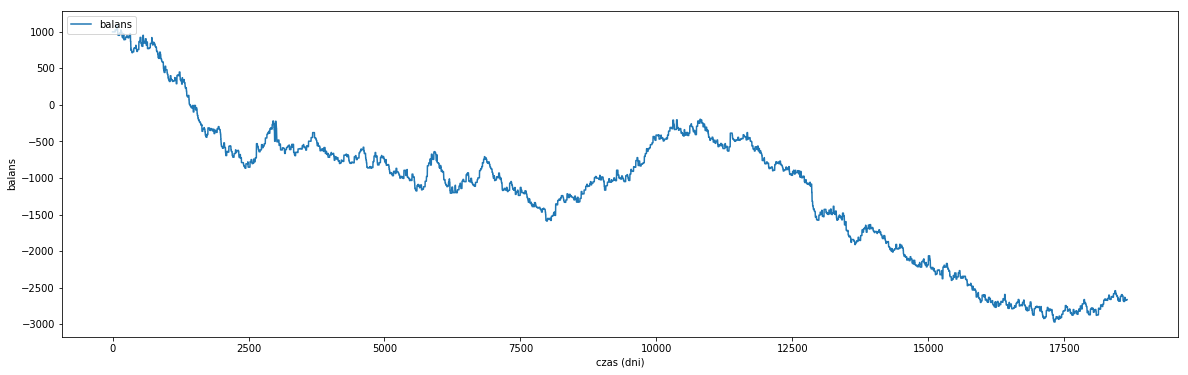

In [18]:
print (balance)
plt.figure(figsize=(20,6))
plt.plot(balanceTab, label="balans")
plt.legend(loc='upper left')
plt.ylabel('balans')
plt.xlabel('czas (dni)')
plt.savefig('test2png.png', dpi=160)
plt.show()

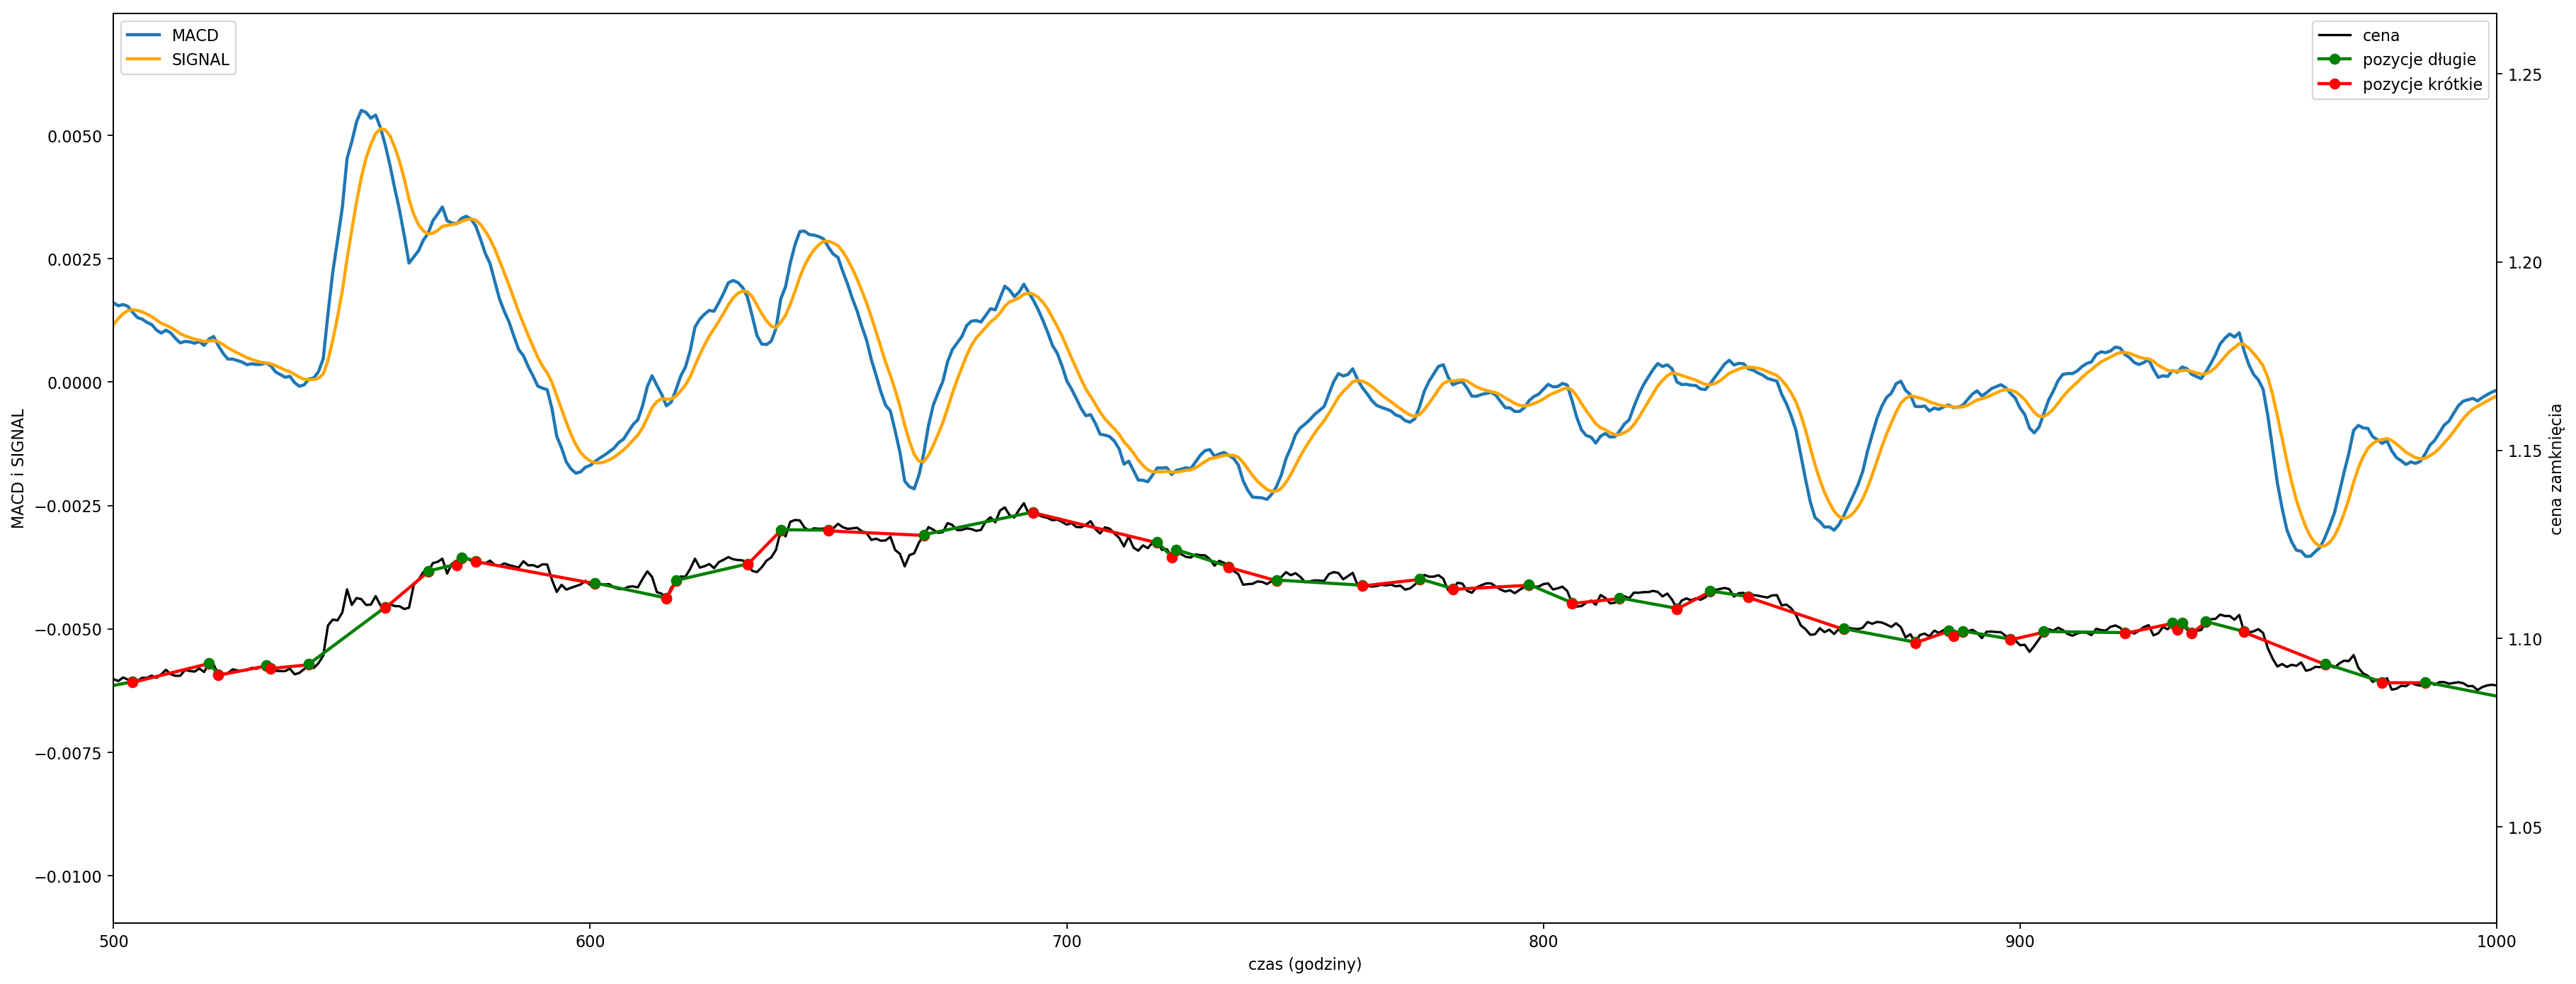

In [14]:
fig, ax1 = plt.subplots()
ax1.plot(timeframe["MACD"], color='tab:blue',linewidth=2)
ax1.plot(timeframe["SIGNAL"], color='orange',linewidth=2)

plt.ylabel('MACD i SIGNAL')
plt.xlabel('czas (dni)')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(timeframe["close"],label='cena', color='black')

plt.plot([-100,-100],[timeframe["close"][0],timeframe["close"][0]], marker = 'o',color='green',linewidth=2,label="pozycje długie")
plt.plot([-100,-100],[timeframe["close"][0],timeframe["close"][0]], marker = 'o',color='red',linewidth=2,label="pozycje krótkie")

prevA = buys[0]
prevB = sells[0]
if buys[0]<sells[0]:
    for a, b in zip(buys, sells):
        plt.plot([a,prevB],[timeframe["close"][a]+spread,timeframe["close"][prevB]], marker = 'o',color='red',linewidth=2)
        plt.plot([a,b],[timeframe["close"][a],timeframe["close"][b]-spread], marker = 'o',color='green',linewidth=2)
        prevA = a
        prevB = b
else:
    for a, b in zip(buys, sells):
        plt.plot([prevA,b],[timeframe["close"][prevA]+spread,timeframe["close"][b]], marker = 'o',color='green',linewidth=2)
        plt.plot([a,b],[timeframe["close"][a],timeframe["close"][b]-spread], marker = 'o',color='red',linewidth=2)
        prevA = a
        prevB = b
        

#plt.plot([100,100],[100,200], marker = 'o')
plt.ylabel('cena zamknięcia')
fig.tight_layout()
fig.set_size_inches(30, 10)
fig.set_dpi(160)
ax1.set_xlim(500, 1000)
#fig = plt.figure(figsize=(20, 10), dpi= 160)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig('books_read.png')
